* This composition is a composition that builds machine learning and deep learning models that distinguish ships from glaciers with satellite images provided by them.
* IMAGE CLASSIFICATION- BINARY CLASSIFICATION
* You can learn a 2-D convolutional neural network (CNN) using keras.
* keras is a famous deep learning framework that builds deep learning models easily and quickly.
* Plotly is a library that enables interactive visulization.

## CNN
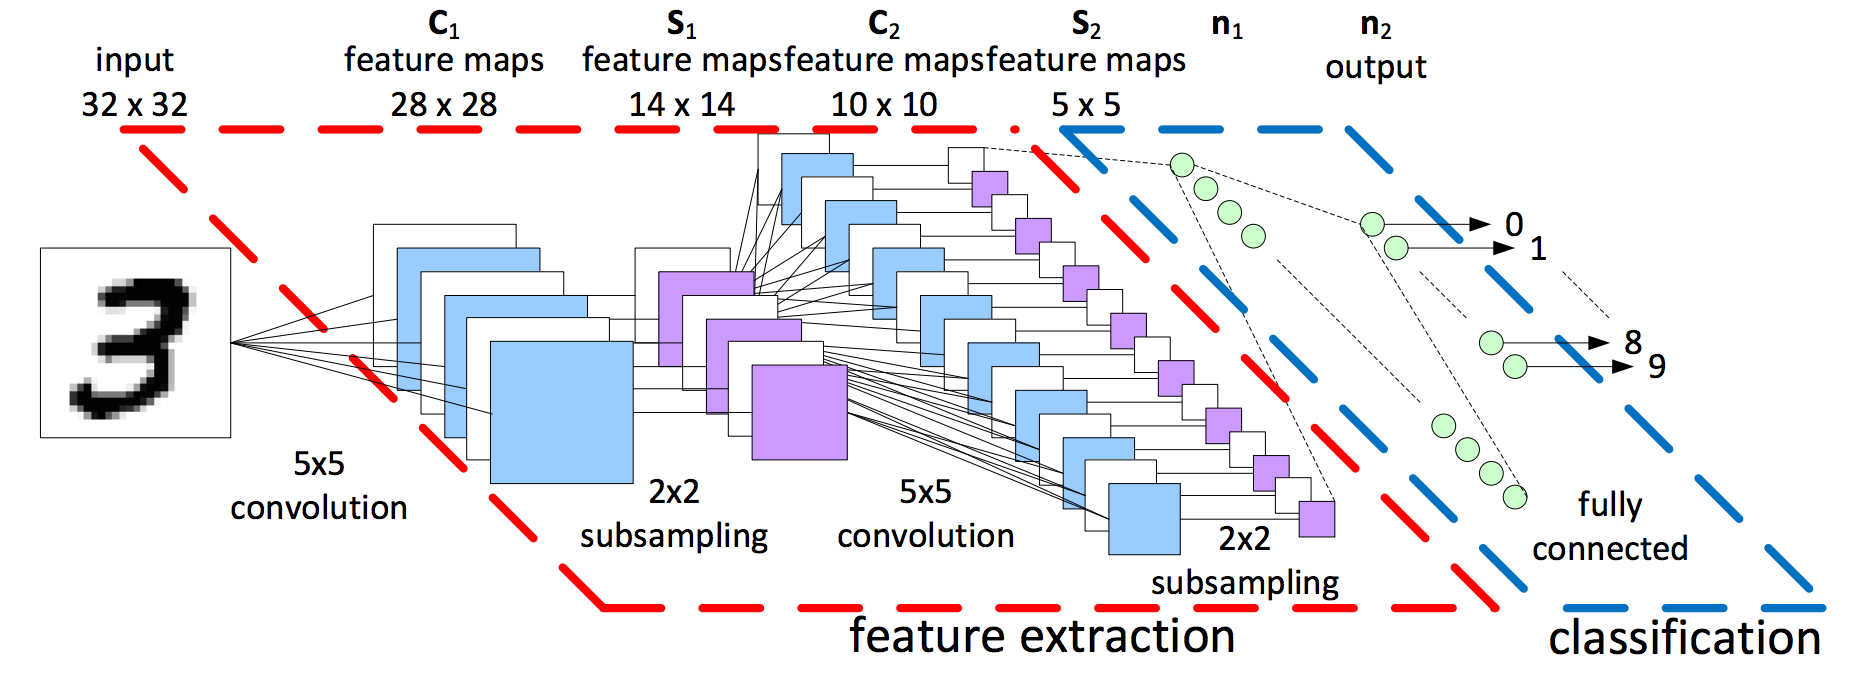
Convolutional Neural Networks (CNNs) learn images directly from data and classify images using patterns as useful algorithms to find patterns to analyze images. 

A key concept of CNN is that it can be learned while maintaining spatial information in images. Because CNN receives data in matrix form to preserve the shape of the image, it can prevent information loss that occurs in the process of vectoring the image. In other words, the underlying concept is "let each element of a filter expressed in a row be automatically learned to suit data processing."



## Import library 

In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split 
from matplotlib import pyplot as plt 

#It makes directly below the code cell that produced it. 
%matplotlib inline 

#Take a look at a iceberg
import plotly.offline as py 
import plotly.graph_objs as go 
from plotly import tools 

#Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

py.init_notebook_mode(connected=True)

* The data are given in the form of json, which is read as pd.read_json rather than as a pd.read_csv.
* Also, this file is in 7z format so that you can open it with the code.

In [ ]:
!pip install py7zr
import py7zr
import os

if not os.path.exists('/kaggle/train/') :
    os.makedirs('/kaggle/train/')

if not os.path.exists('/kaggle/test/') :
    os.makedirs('/kaggle/test/')

with py7zr.SevenZipFile("/kaggle/input/statoil-iceberg-classifier-challenge/train.json.7z", 'r') as archive:
    archive.extractall(path="/kaggle/train")

with py7zr.SevenZipFile("/kaggle/input/statoil-iceberg-classifier-challenge/test.json.7z", 'r') as archive:
    archive.extractall(path="/kaggle/test")

for dirname, _, filenames in os.walk('/kaggle'): 
    for filename in filenames: 
        print(os.path.join(dirname, filename))

In [ ]:
train = pd.read_json('/kaggle/train/data/processed/train.json')
test = pd.read_json('/kaggle/test/data/processed/test.json')

In [ ]:
train.head()

If you look at the shape of the data,

* **id**
* **feature**: band_1, band_2, inc_angle
* **target**: is_iceberg -> iceberg = 1, ship = 0

The images say that the radar shot from the satellite meets a specific object and bounced back, which was saved as an image.

The more solid objects (land, islands, sea ice, icebergs, ships) are said to reflect stronger rader energy, resulting in brighter images. This is called backscatter.

**"backscatter"** is heavily influenced by the surrounding environment, and the stronger the wind around it, the brighter the image, the weaker the wind, the darker it is already, and I think the kinetic energy of many molecules in the strong wind is reflected and put on the radar.

Straightening this image is a lateral surveillance radar that takes images from a certain angle. inc_angle means an angle that looks at **band_1.band_2**.

In general, the higher the **incidence angle**, the better the ocean background is.

**Band_1, band_2** can be thought of as an image.

In [ ]:
train['inc_angle'].value_counts()

If you look at it, there is **'na'** at the top, and you can think of it as a miss value. So I'm going to change this 'na' -> '0'


In [ ]:
#na -> 0
train.inc_angle = train.inc_angle.replace('na',0)

In [ ]:
#Check out the length
len(train.loc[0,'band_1'])

* They are 5625 long and change the size to 75x75 to make images (**75x75 = 5625**) easier to learn in order to learn them, and to have [N, height, width, channel] dimensions for 2D. 
* np.newaxis makes it easy to use.

In [ ]:
#Generate the training data 
#Create 3 bands having HH, HV, avg of both 
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in train['band_2']])
#Use 'np.concatenate' to make a new channel for a color image 
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

X_band_test_1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in test['band_1']])
X_band_test_2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in test['band_2']])

X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis],
                         X_band_test_2[:, :, :, np.newaxis],
                         ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

In conclusion, this is the code that gets an image of three channels by changing it like this. Both train data and test data were performed.

## Example of image Visualization
We can find that the visualized shape varies depending on the **angle of incidence**. Even if it was a same picture. 


In [ ]:
#For example, let's see 14 sample
train.loc[14, 'is_iceberg']

In [ ]:
#We can see that even if the pic is same, but different depend on band1,2
band1 = X_band_1[14,:,:]
band2 = X_band_2[14,:,:]
#We use 'from plotly import tools'-> import tools
fig = tools.make_subplots(rows=1,cols=2, specs=[[{'is_3d': True}, {'is_3d':True}]])
data = go.Surface(z=band1, colorscale='RdBu_r', scene='scene1', showscale=True)
data1 = go.Surface(z=band2, colorscale='RdBu_r', scene='scene2', showscale=True)

fig['layout'].update(title='3D surface plot for example14 ', titlefont=dict(size=30), height=600, width=800)

fig.append_trace(data,1,1)
fig.append_trace(data1,1,2)
py.iplot(fig)

The red peak represents the shape of the ship, and depending on HH and HV, the direction seen by the radar varies slightly, but it can be seen that it eventually represents the same thing.

In [ ]:
#This picture is only viewed from above without considering the z axis.
plt.imshow(band1)
plt.show()

## Make 3D surface plot 

In [ ]:
#Make 3D surface plot 
label = 'ship'

fig = tools.make_subplots(rows=1, cols=2,  specs=[[{'is_3d': True}, {'is_3d': True}]])
fig.append_trace(dict(type='surface', z=band1, colorscale='RdBu_r', scene='scene1', showscale=False), 1, 1)
fig.append_trace(dict(type='surface', z=band2, colorscale='RdBu_r', scene='scene2', showscale=False), 1, 2)

#The bottom part is setting size and the title of fig
fig['layout'].update(title='3D surface plot for "{}" (left is from band1, right is from band2)'.format(label), titlefont=dict(size=30), height=600, width=800)

py.iplot(fig)

## Better way to make 3D subplot
* Fist we make an 'plot_contour_2d' function
* Next, choose the value in the setted function to confirm the num that we want to see 

In [ ]:
#Use 'def' function to make it 
def plot_contour_2d(band1, band2, label):
    fig = tools.make_subplots(rows=1, cols=2, specs=[[{'is_3d': True}, {'is_3d':True}]])
    fig.append_trace(dict(type='surface', z=band1, colorscale='RdBu_r', scene='scene1', showscale=False), 1, 1)
    fig.append_trace(dict(type='surface', z=band2, colorscale='RdBu_r', scene='scene2', showscale=False), 1, 2)
    
    fig['layout'].update(title='3D surface plot for "{}" (left is from band1, right is from band2)'.format(label), titlefont=dict(size=30), height=600, width=800)
    
    py.iplot(fig)
    
#The bottom part here is now a code that shows the top view without the z axis.   
    fig, ax = plt.subplots(1,2,figsize=(16,10))
    ax[0].imshow(X_band_1[num,:,:])
    ax[0].set_title('Image from band_1', fontsize=15)
    ax[1].imshow(X_band_2[num,:,:])
    ax[1].set_title('Image from band_2', fontsize=15)
    plt.show()

You can now enter a number in the num section below to see what we want.


In [ ]:
num = 0
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else'ship'
plot_contour_2d(X_band_1[num,:,:], X_band_2[num,:,:], label)

In [ ]:
#Check out num 100
num =100 
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else 'ship'
plot_contour_2d(X_band_2[num,:,:], X_band_2[num,:,:], label)

It's a little different from num = 0, but you can see other glaciers besides the peak.

## Start Deep Learning
* Let's start deep learning now! The dataset is ready, so you can design a neural network model.
* Since it's an image, do it with a 2D CNN. Keras has several layers built into it that are used for deep learning, so we just need to stack them like blocks.

In [ ]:
#Import Keras 
from matplotlib import pyplot 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
#Stop learning if the loss does not decrease further through keras.callbacks.
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

# Overall workflow
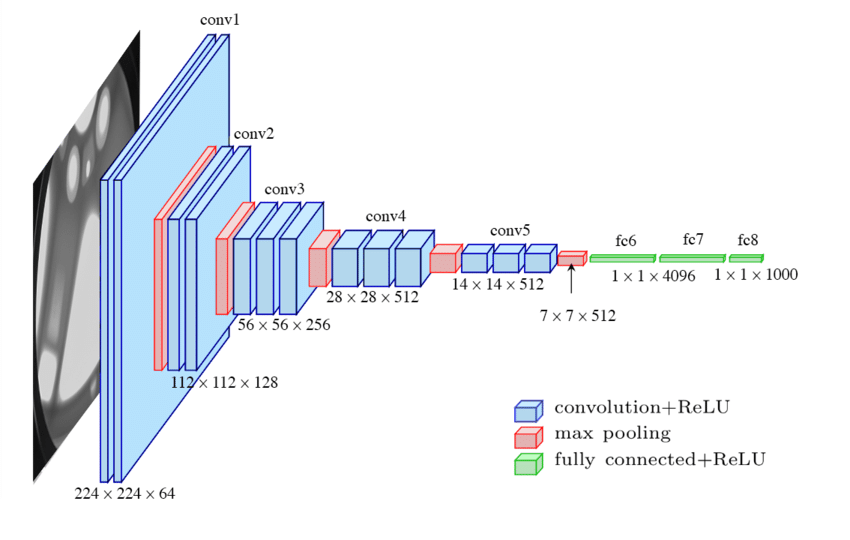

In [ ]:
#define our model
def getModel():
    #Buildin the model
    gmodel = Sequential()
    #Conv Layer1
    gmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(75,75,3)))
    gmodel.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    gmodel.add(Dropout(0.2))
    
    #Conv Layer2
    gmodel.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    gmodel.add(Dropout(0.2))
    
    #Conv Layer3
    gmodel.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    gmodel.add(Dropout(0.2))
    
    #Conv Layer4
    gmodel.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    gmodel.add(Dropout(0.2))
    
    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())
    
    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))
    
    #Sigmoid Layer
    #Adam makes model Optimization
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))
    
    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy', optimizer=mypotim, metrics=['accuracy'])
    gmodel.summary()
    return gmodel

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode='min')
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = '.model_weights.hdf5'
callbacks = get_callbacks(filepath=file_path, patience=5)

### 1. Conv2D
 : A method used a lot in image processing because it is mainly specialized in image processing.

gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))

* First factor: 64 -> The number of convolutional filters(= number of neurons connected)
* Second factor: kernel_size = (3,3) -> (row, column) of the convolutional kernel
* Number three factor: activation='relu' -> activation function setting, rectifier function, mainly used in the beneficial layer
* +relu: A function that returns 0 if the value is less than 0 and returns the value if the value is greater than 0.
* Number 4 factor: input_shpae (75, 75, 3) -> size 75×75 and color photo (RGB), so channel 3, channel 1 if black and white

**Relu**
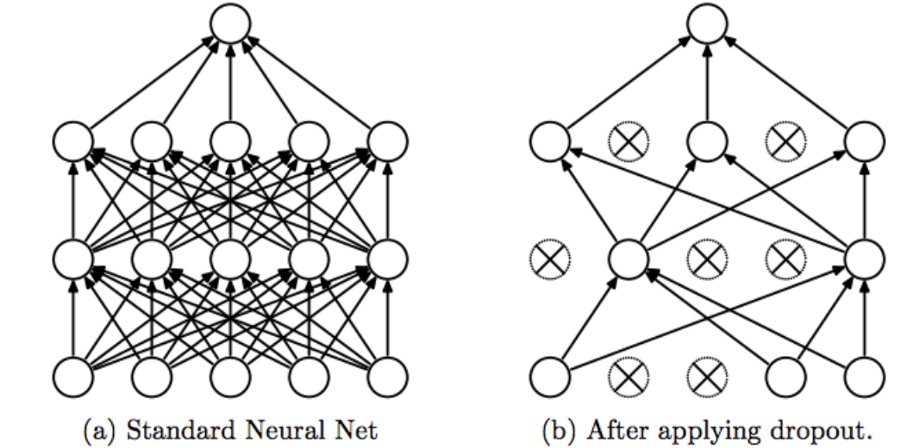
* x>0 is a straight line with a slope of 1, and x<0 is a function value of 0.
* Learning is much faster when compared to the sigmoid and tanh functions.
* The computational cost is not significant, and the implementation is very simple.
* For values with x <0, there is a disadvantage that neurons can die because the slope is zero.

**Input Shape**
:75 x 75, 3 = because it is a color image

### 2. MaxPooling2D
goal->
* Input size is reduced: the convolution layer is repeated several times, and all data that is not needed is not analyzed. By drawing out the characteristics, you're learning.
* Overfitting: A decrease in input size can be thought of as a decrease in the number of useless parameters. Overfitting, which exhibits high performance only for training data, can be reduced.
* Pulling out features well : When pooling, it can recognize certain shapes better.

**pool_size**:Tuples of integers or two integers, reduced arguments (horizontal and vertical). (2, 2) reduces the input in half for two spatial dimensions. If only one integer is specified, the same window length applies for both dimensions.

**strides**: Integer, Tuple of 2 integers, or None. The stride value. If None, the default value is pool_size.

### 3. Dropout
: Dropout is a way to solve Overfitting, one of the problems in deep learning learning. In summary, some units in the hidden layer are prevented from being overfitted by preventing them from operating.
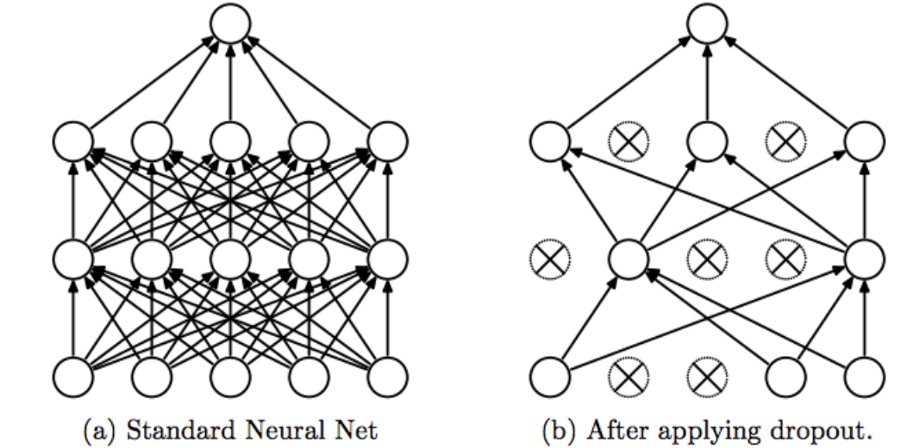
We can easily think dropout is a proess to making the model less intelligent.

## Model Evaluation
* Instead of testing it right away for a better model, we evaluate the model first by dividing the existing train set into trains and valids.
* Sklearn built-in function train_test_split makes it easy.

In [ ]:
target_train = train['is_iceberg']
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      target_train,
                                                      random_state=1,
                                                      train_size = 0.8)

In [ ]:
#Without denoising, core features
gmodel = getModel()
gmodel.fit(X_train, y_train,
           batch_size=24,
           epochs=10,
           verbose=1,
           validation_data=(X_valid, y_valid),
           callbacks=callbacks)

* **batch_size** = Set how many samples to update the weight.

For example, if the batch size is 10, every 10 pieces of data is compared to the actual label value, so even if you initially predict incorrectly, you are more likely to update the weights and then fit them.Smaller batch sizes will make the learning dense, but it will take a long time throughout the process of continuing to compare with labels and updating weights.

* **epochs** = Set how many iterations of the entire dataset you want to learn.

Repeated learning can improve the performance of your model. However, too much repetitive learning can lead to overfitting, which increases performance for the learning set, but decreases performance for the unobserved test set. Therefore, if overfitting is likely to occur, end the learning.
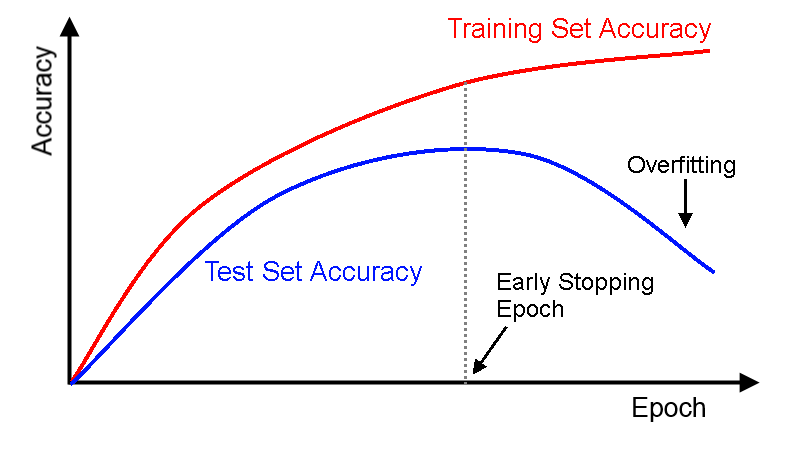

* **Verbose** = Sets the phrase that is output during learning.
- 0 : Outputs nothing.
- 1: Show progress bar showing progress of training.
- 2: Output loss information for each mini-batch.

Next, Recall the saved weight again to check the loss and accuracy for the validation set. (recall -> **file_path**)

In [ ]:
#Recall saved weight 
gmodel.load_weights(filepath = file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
#X_test = concatenate X_band_test1 and test2
predicted_test = gmodel.predict_proba(X_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)

### Reference
Thank you for his best lecture ever!! I made more detailed by listening his lecture! It will be really helpful for starter.

Check out 'You Han Lee' youtube and his kaggle.
https://www.kaggle.com/youhanlee

https://www.youtube.com/watch?v=uVoagNbaSwo&t=3s